## Load data

Load the data and also resize and flip the widefield so the pixel size and coordinate system matches the restored

In [1]:
import mrc as Mrc
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os 
parent_path = r'D:\Janelia\Data 2024-06-12'

output=Mrc.Mrc(os.path.join(parent_path, 'data/561nm WF correlation image 2_20240521_162301/560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc_560 201909_19-20_best_gApo_0.2_supR_1.5_w_0.001_tile64_pad32.mrc'))
restored = output.data
widefield = imread(os.path.join(parent_path, '561nm Widefield no SIM illumination image 8.75 microns stack.tif'))

# get pixel spacings of restored
sxy, sxy, sz = output.header.d[0], output.header.d[1], output.header.d[2]

# I assume widefield has twice the xy pixel size as restored but same z pixel size (not sure if this is correct)
# so resize widefield so pixel size matches output
# default pixel interpolation of sksize is bilinear
widefield = resize(widefield, output.shape, anti_aliasing=True, preserve_range=True)
# flip vertically
widefield = widefield[:,::-1,:]

c:\Users\bnort\miniconda3\envs\simrecon_python_373\lib\site-packages\skimage\external\tifffile\tifffile.py:2133: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


## Show max projection of entire image

Show a max projection of the entire image so we can confirm both restored and widefield contain the same objects (they will likely be shifted)

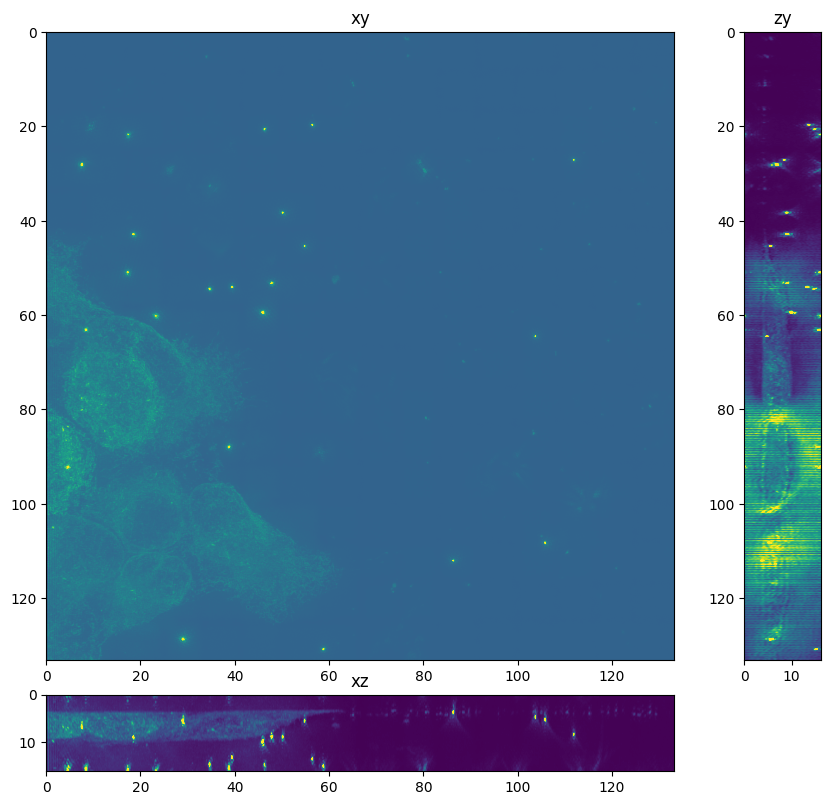

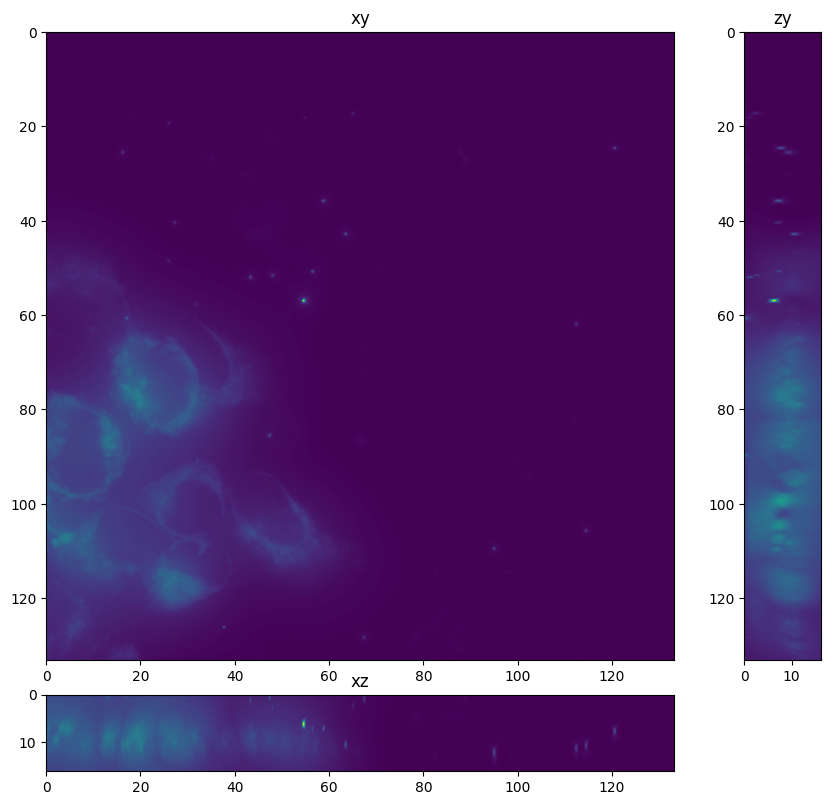

In [2]:
from tnia.plotting.projections import show_xyz_max

fig = show_xyz_max(restored, sxy=sxy, sz=sz, vmax = restored.max()/10)
fig = show_xyz_max(widefield, sxy=sxy, sz=sz, vmax = widefield.max())


## Find aproximate bead locations and then use interactive slice viewer to find exact centers

We used ImageJ to locate the same bead in the restored and widefield

In [3]:
from tnia.plotting.interactive_projections import show_xyz_slice_interactive
454, 274

def get_center_crop(data, yc, xc, w, h):
    index = np.s_[:,yc-h:yc+h,xc-w:xc+w]
    return data[index]

# the coordinates used below were determined by looking at the images in ImageJ
restored_crop = get_center_crop(restored, 587, 770, 100, 100)
widefield_crop = get_center_crop(widefield, 558, 908, 100, 100)

print(restored_crop.shape)
#fig = show_xyz_sum(crop, sxy=1, sz=1)
#fig = show_xyz_slice(crop, zc, h//2, w//2, sxy=1, sz=1)
fig = show_xyz_slice_interactive(widefield_crop)


(65, 200, 200)


interactive(children=(IntSlider(value=100, description='x', max=199), IntSlider(value=100, description='y', ma…

Text(0.5, 0.98, 'Widefield')

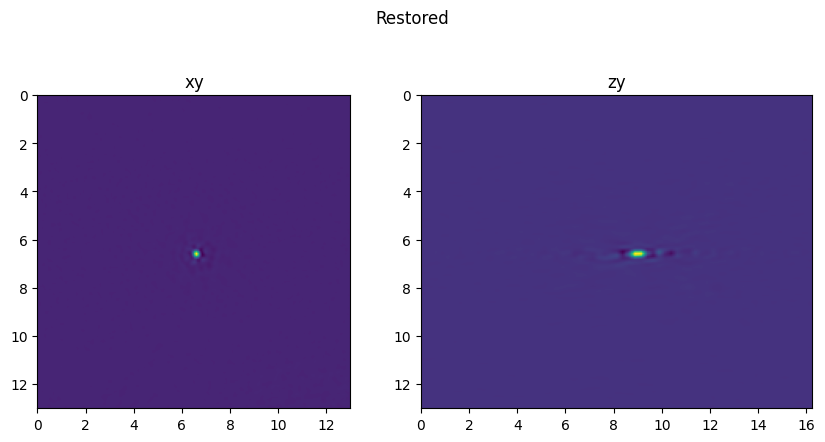

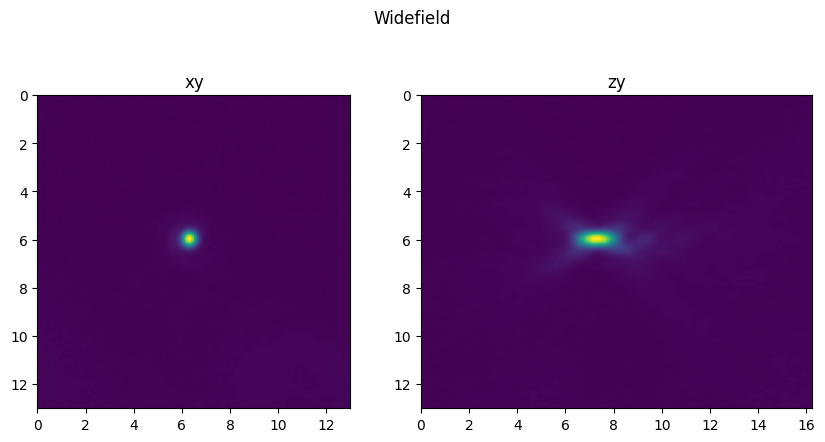

In [4]:
from tnia.plotting.projections import show_xy_zy_slice

# define location of bead in crop for restored and widefield (these were determined by tweaking the cross hairs in the interactive plot above)
xcr, ycr, zcr = 101, 101, 35
xcw, ycw, zcw = 97, 93, 29
fig = show_xy_zy_slice(restored_crop, xcr, ycr, zcr, sxy=sxy, sz=sz, figsize=(10,5))
fig.suptitle('Restored')
fig = show_xy_zy_slice(widefield_crop, xcw, ycw, zcw, sxy=sxy, sz=sz, figsize=(10,5))
fig.suptitle('Widefield')

Text(0.5, 1.0, 'Widefield XY Profile')

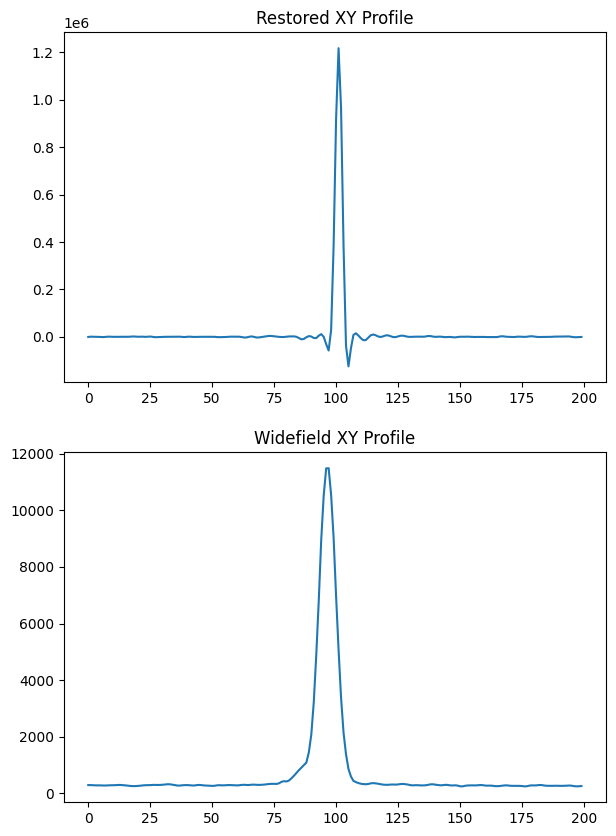

In [5]:
import matplotlib.pyplot as plt

xy_profile_restored = restored_crop[zcr,ycr,:]
xy_profile_widefield = widefield_crop[zcw,ycw,:]

fig, ax = plt.subplots(2,1, figsize=(7,10))

ax[0].plot(xy_profile_restored)
ax[0].set_title('Restored XY Profile')
ax[1].plot(xy_profile_widefield)
ax[1].set_title('Widefield XY Profile')

Text(0.5, 1.0, 'Widefield Z Profile')

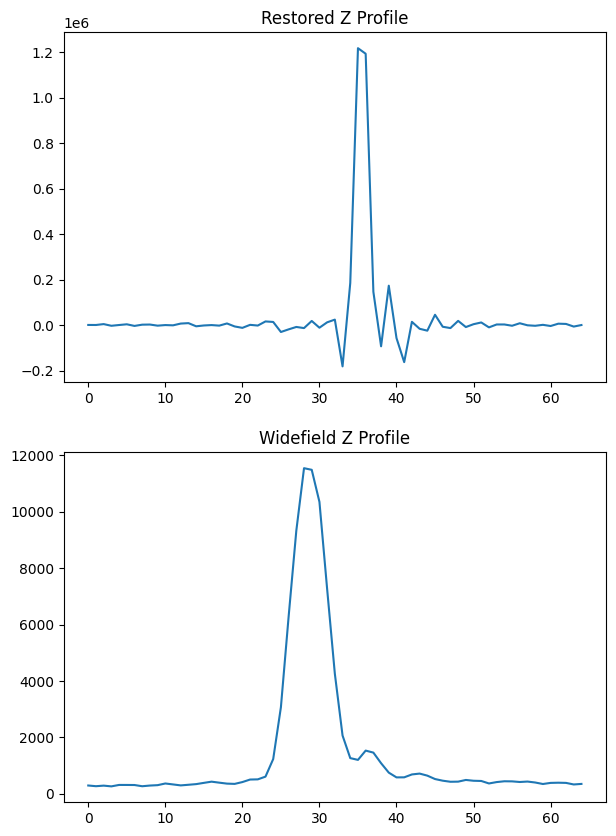

In [6]:
z_profile_restored = restored_crop[:,ycr,xcr]
z_profile_widefield = widefield_crop[:,ycw,xcw]

fig, ax = plt.subplots(2,1, figsize=(7,10))

ax[0].plot(z_profile_restored)
ax[0].set_title('Restored Z Profile')
ax[1].plot(z_profile_widefield)
ax[1].set_title('Widefield Z Profile')
